In [43]:
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump

%matplotlib inline

In [44]:
##读取数据
Database=pd.read_csv("Database2023429.csv",index_col=None)
X=Database.iloc[:,:-1]
rt=Database.iloc[:,-1]

In [45]:
#用get_dummies方法对名称字段进行onehot编码
X=pd.DataFrame(X,columns=['核苷种类','A溶剂','A添加剂种类mmol','A添加剂种类%','B溶剂','B添加剂种类mmol','B添加剂种类%','H','S*','A','B','C (pH 2.8)','C (pH 7.0)','色谱柱调料粒径','色谱柱长度','色谱柱内径','柱温','A添加剂种类浓度mmol','A添加剂种类浓度%','B添加剂种类浓度mmol','B添加剂种类浓度%','时间min','比例A','时间min.1','比例A.1','时间min.2','比例A.2','时间min.3','比例A.3','时间min.4','比例A.4','时间min.5','比例A.5','时间min.6','比例A.6','时间min.7','比例A.7','时间min.8','比例A.8','时间min.9','比例A.9','流速','进样量'])
X_needencoder=X.iloc[:,:7]
X_needencoder_dummy=pd.get_dummies(X_needencoder,columns=X_needencoder.columns)
X.drop(['核苷种类','A溶剂','A添加剂种类mmol','A添加剂种类%','B溶剂','B添加剂种类mmol','B添加剂种类%'],axis=1,inplace=True)


In [46]:
from sklearn.preprocessing import StandardScaler
# 特征缩放
scaler = StandardScaler()
X_num = X.select_dtypes(include=['float64'])  # 选取连续的数值变量
X_num_scaled = scaler.fit_transform(X_num)
X_num_scaled = pd.DataFrame(X_num_scaled, columns=X_num.columns)
X=pd.concat([X_num_scaled,X_needencoder_dummy],axis=1)

In [47]:
##分训练集、测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, rt, test_size=0.2, shuffle=True)


K折交叉验证得分： [0.6109379738302216, 0.6281102379686159, 0.6569647347253218, 0.5691891064969425, 0.3490332317614091]
最佳模型的MSE： 18.548591350886593
模型性能： 0.8154374925763915


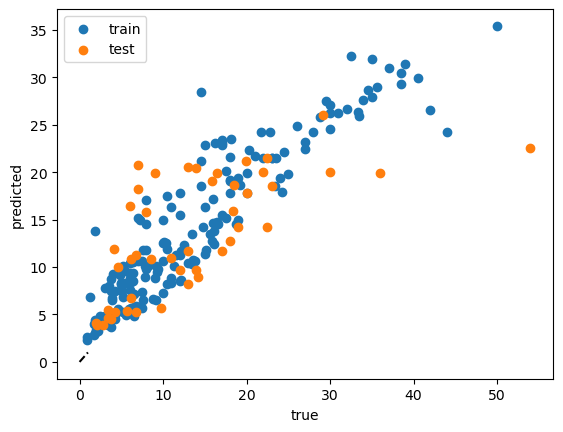

In [48]:


kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
X_train=pd.DataFrame(X_train)
for train_index, test_index in kf.split(X_train):
    X_train_kf, X_test_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_test_kf = Y_train.iloc[train_index], Y_train.iloc[test_index]
    model.fit(X_train_kf, y_train_kf)
    score = model.score(X_test_kf, y_test_kf)
    scores.append(score)
print('K折交叉验证得分：', scores)


from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# 定义管道
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor())
])

# 定义参数空间
param_grid = {
    'reg__n_estimators': [50, 100, 200, 500],
    'reg__max_features': ['sqrt', 'log2'],
    'reg__max_depth': [3, 5, 10, 20, None],
    'reg__min_samples_split': [2, 5, 10],
    'reg__min_samples_leaf': [1, 2, 4],
    'reg__random_state': [42],
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False]
}

# 定义GridSearchCV对象
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 运行GridSearchCV进行调参
grid.fit(X, rt)

# 得到最佳模型和参数
best_model = grid.best_estimator_
best_params = grid.best_params_

# 使用最佳模型进行预测和评估
y_pred=best_model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print('最佳模型的MSE：', mse)
dump(best_model, 'random_forest_model.joblib')

# 使用测试集验证模型性能
score1 = best_model.score(X_test, Y_test)
print('模型性能：', score1)

# 绘制回归曲线
best_model.fit(X_train, Y_train)
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
plt.scatter(Y_train, y_pred_train, label='train')
plt.scatter(Y_test, y_pred_test, label='test')
plt.plot([0, 1], [0, 1], '--', color='black')
plt.xlabel('true')
plt.ylabel('predicted')
plt.legend()
plt.show()